<a href="https://colab.research.google.com/github/christiano1974/portifolios-trabalho/blob/main/C%C3%B3pia_de_credito_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Trabalho realizado no Kaggle. (Avaliação de crédito)
# Foi realizado uma análise exploratória e depois foi elaborado um modelo de regressão logística.
# Christiano.

# Importação dos dados, limpeza dos dados e tratamento dos dados.

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'loan-status-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4390452%2F7539897%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240215%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240215T202848Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D109b440fe8fc13e1ce314dde83f09eeb4f60af17cdb1bc7cf97aa3e67bd8467864ecb0bbe1e80fe4d80ec7e52c27c86c59dfbbd349545823a8da1fbd6f2a6b45e0e8814b9378a520d34d1516d989eeffe2c55a7a07cfcea7db6887f95b8432d2ca18f2f6b04219b48d66c2d217ba592eca10ac15fdf1917fbd03d4a386d476759f2fb20aeedb0233ab786956d96b1c5c1250e4fa880099966374c297c4dd67605b24313dfdf2f27b46ce86e787fc55a83b6fd2b4a91280995a9e0a50f18df011a9d0ed2d2423fa146fdf030ea1007b4f5708f008c38255a72faec0ad5802734fa1b4863c0f070012a6e45b42df4b917b46b2c6502d31e99c78c91d27f5b04bd6'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/loan-status-prediction/loan_data.csv


In [ ]:
df = pd.read_csv('/kaggle/input/loan-status-prediction/loan_data.csv')

In [ ]:
df.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
2,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
3,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
4,LP001013,Male,Yes,0,Not Graduate,No,2333,1516.0,95.0,360.0,1.0,Urban,Y


In [ ]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381 entries, 0 to 380
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            381 non-null    object 
 1   Gender             376 non-null    object 
 2   Married            381 non-null    object 
 3   Dependents         373 non-null    object 
 4   Education          381 non-null    object 
 5   Self_Employed      360 non-null    object 
 6   ApplicantIncome    381 non-null    int64  
 7   CoapplicantIncome  381 non-null    float64
 8   LoanAmount         381 non-null    float64
 9   Loan_Amount_Term   370 non-null    float64
 10  Credit_History     351 non-null    float64
 11  Property_Area      381 non-null    object 
 12  Loan_Status        381 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 38.8+ KB


In [ ]:
df.isna().sum()

Loan_ID               0
Gender                5
Married               0
Dependents            8
Education             0
Self_Employed        21
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            0
Loan_Amount_Term     11
Credit_History       30
Property_Area         0
Loan_Status           0
dtype: int64

In [ ]:
df.dropna(inplace = True)

In [ ]:
df.isna().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

# Análise descritiva dos dados.

In [ ]:
df.shape

(308, 13)

In [ ]:
df[df.Loan_Status == "Y"].describe().round(2)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,219.00,219.00,219.00,219.00,219.00
mean,3630.70,1275.95,105.62,340.77,0.99
std,1516.45,1833.37,30.06,65.38,0.12
min,645.00,0.00,17.00,60.00,0.00
25%,2554.50,0.00,90.00,360.00,1.00
50%,3273.00,1041.00,111.00,360.00,1.00
75%,4208.50,2024.50,129.50,360.00,1.00
max,9703.00,20000.00,150.00,480.00,1.00


In [ ]:
df[df.Loan_Status == "N"].describe().round(2)

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,89.00,89.00,89.00,89.00,89.00
mean,3521.43,1284.54,102.18,342.20,0.53
std,1324.77,3720.80,27.66,75.23,0.50
min,150.00,0.00,9.00,36.00,0.00
25%,2600.00,0.00,81.00,360.00,0.00
50%,3400.00,0.00,105.00,360.00,1.00
75%,4333.00,1800.00,121.00,360.00,1.00
max,7660.00,33837.00,150.00,480.00,1.00


In [ ]:
df.dtypes

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [ ]:
print('status = Yes')
print(df[df.Loan_Status == "Y"].Married.value_counts())
print("")
print('status = No')
print(df[df.Loan_Status == "N"].Married.value_counts())

status = Yes
Married
Yes    140
No      79
Name: count, dtype: int64

status = No
Married
Yes    45
No     44
Name: count, dtype: int64


In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

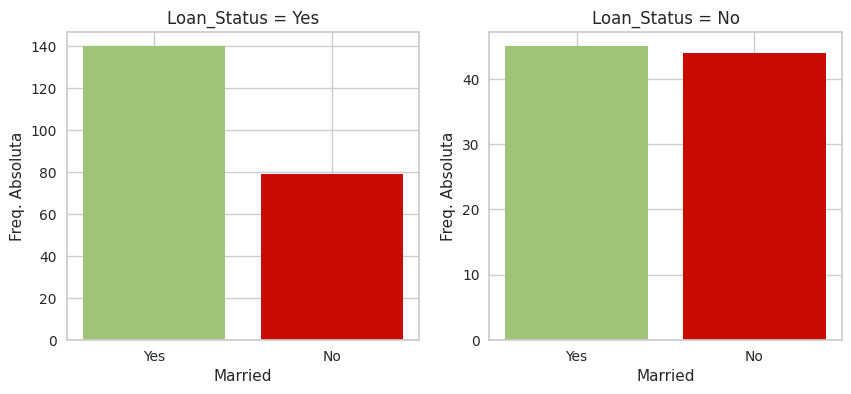

In [ ]:
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.bar(['Yes','No'],[140,79],color = ['g','r'])
plt.xlabel('Married',fontsize = 11)
plt.ylabel('Freq. Absoluta')
plt.title('Loan_Status = Yes')
plt.subplot(122)
plt.bar(['Yes','No'],[45,44],color = ['g','r'])
plt.xlabel('Married',fontsize = 11)
plt.ylabel('Freq. Absoluta')
plt.title('Loan_Status = No')
plt.show()

In [ ]:
print('status = Yes')
print(df[df.Loan_Status == "Y"].Gender.value_counts())
print("")
print('status = No')
print(df[df.Loan_Status == "N"].Gender.value_counts())

status = Yes
Gender
Male      179
Female     40
Name: count, dtype: int64

status = No
Gender
Male      66
Female    23
Name: count, dtype: int64


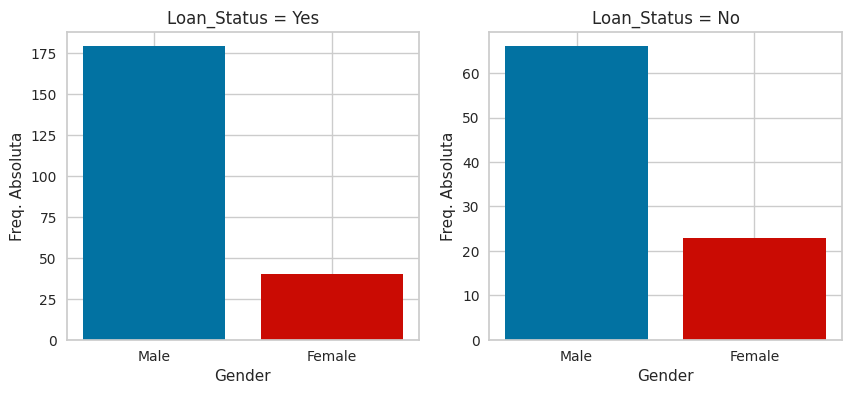

In [ ]:
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.bar(['Male','Female'],[179,40],color = ['b','r'])
plt.xlabel('Gender')
plt.ylabel('Freq. Absoluta')
plt.title('Loan_Status = Yes')
plt.subplot(122)
plt.bar(['Male','Female'],[66,23],color = ['b','r'])
plt.xlabel('Gender')
plt.ylabel('Freq. Absoluta')
plt.title('Loan_Status = No')
plt.show()

In [ ]:
print('status = Yes')
print(df[df.Loan_Status == "Y"].Education.value_counts())
print("")
print('status = No')
print(df[df.Loan_Status == "N"].Education.value_counts())

status = Yes
Education
Graduate        166
Not Graduate     53
Name: count, dtype: int64

status = No
Education
Graduate        63
Not Graduate    26
Name: count, dtype: int64


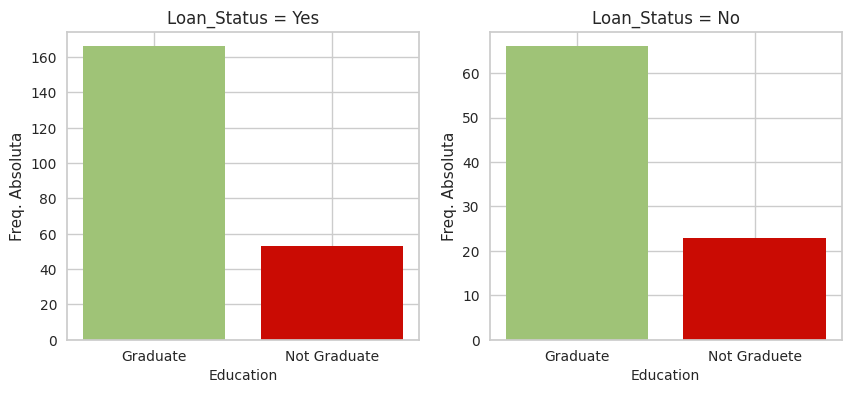

In [ ]:
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.bar(['Graduate','Not Graduate'],[166,53],color = ['g','r'])
plt.xlabel('Education',fontsize = 10)
plt.ylabel('Freq. Absoluta')
plt.title('Loan_Status = Yes')
plt.subplot(122)
plt.bar(['Graduate','Not Graduete'],[66,23],color = ['g','r'])
plt.xlabel('Education',fontsize = 10)
plt.ylabel('Freq. Absoluta')
plt.title('Loan_Status = No')
plt.show()

In [ ]:
print('Loa_Status = Yes')
print(df[df.Loan_Status == "Y"].Dependents.value_counts())
print("")
print('Loa_Status = No')
print(df[df.Loan_Status == "N"].Dependents.value_counts())

Loa_Status = Yes
Dependents
0     137
2      35
1      29
3+     18
Name: count, dtype: int64

Loa_Status = No
Dependents
0     57
1     14
2     12
3+     6
Name: count, dtype: int64


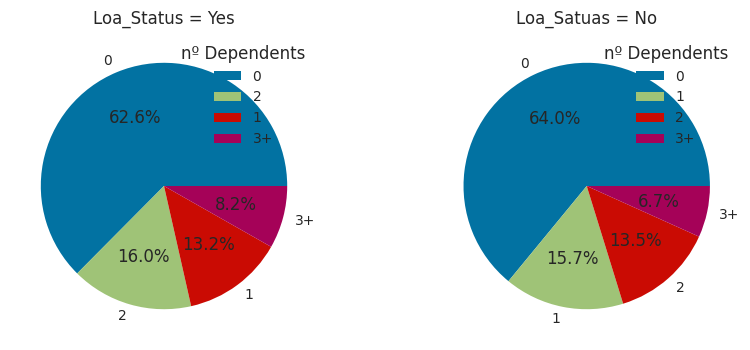

In [ ]:
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.pie(x = [137,35,29,18],labels = ['0','2','1','3+'],autopct = '%1.1f%%')
plt.title('Loa_Status = Yes')
plt.legend(title = 'nº Dependents',labels = ['0','2','1','3+'],loc = 'upper right')
plt.subplot(122)
plt.pie(x = [57,14,12,6],labels = ['0','1','2','3+'],autopct = '%1.1f%%')
plt.title('Loa_Satuas = No')
plt.legend(title = 'nº Dependents',labels = ['0','1','2','3+'],loc = 'upper right')
plt.show()

In [ ]:
print('Loa_Status = Yes')
print(df[df.Loan_Status == "Y"].Self_Employed.value_counts())
print("")
print('Loa_Status = No')
print(df[df.Loan_Status == "N"].Self_Employed.value_counts())

Loa_Status = Yes
Self_Employed
No     201
Yes     18
Name: count, dtype: int64

Loa_Status = No
Self_Employed
No     79
Yes    10
Name: count, dtype: int64


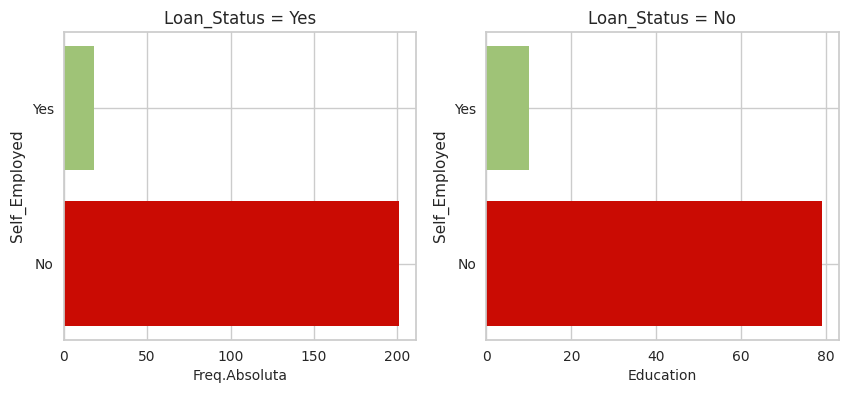

In [ ]:
plt.figure(figsize = (10,4))
plt.subplot(121)
plt.barh(['No','Yes'],[201,18],color = ['r','g'])
plt.xlabel('Freq.Absoluta',fontsize = 10)
plt.ylabel('Self_Employed')
plt.title('Loan_Status = Yes')
plt.subplot(122)
plt.barh(['No','Yes'],[79,10],color = ['r','g'])
plt.xlabel('Education',fontsize = 10)
plt.ylabel('Self_Employed')
plt.title('Loan_Status = No')
plt.show()

In [ ]:
print('Loa_Status = Yes')
print(df[df.Loan_Status == "Y"].Property_Area.value_counts())
print("")
print('Loa_Status = No')
print(df[df.Loan_Status == "N"].Property_Area.value_counts())

Loa_Status = Yes
Property_Area
Semiurban    100
Urban         66
Rural         53
Name: count, dtype: int64

Loa_Status = No
Property_Area
Rural        33
Urban        33
Semiurban    23
Name: count, dtype: int64


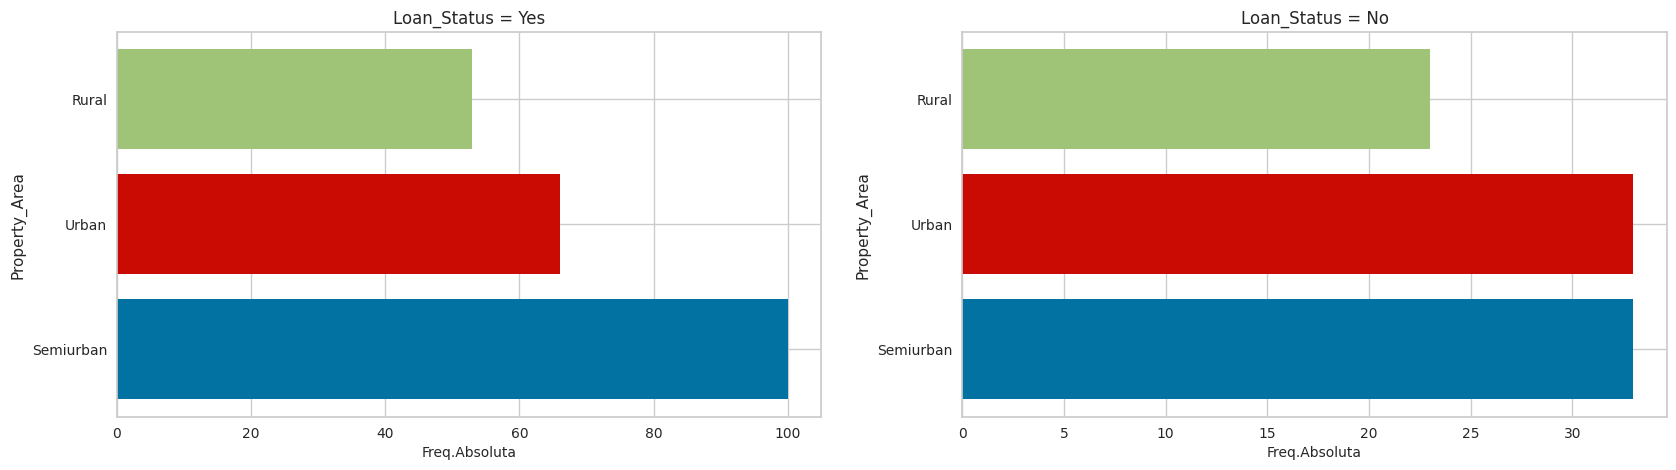

In [ ]:
plt.figure(figsize = (20,5))
plt.subplot(121)
plt.barh(['Semiurban','Urban','Rural'],[100,66,53],color = ['b','r','g'])
plt.xlabel('Freq.Absoluta',fontsize = 10)
plt.ylabel('Property_Area')
plt.title('Loan_Status = Yes')
plt.subplot(122)
plt.barh(['Semiurban','Urban','Rural'],[33,33,23],color = ['b','r','g'])
plt.xlabel('Freq.Absoluta',fontsize = 10)
plt.ylabel('Property_Area')
plt.title('Loan_Status = No')
plt.show()

In [ ]:
df.iloc[:,6:11].corr()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
ApplicantIncome,1.000000,-0.243677,0.267628,-0.099571,0.030307
CoapplicantIncome,-0.243677,1.000000,0.123028,-0.004158,0.012715
LoanAmount,0.267628,0.123028,1.000000,0.135069,-0.043853
Loan_Amount_Term,-0.099571,-0.004158,0.135069,1.000000,0.015269
Credit_History,0.030307,0.012715,-0.043853,0.015269,1.000000


In [ ]:
import seaborn as sns

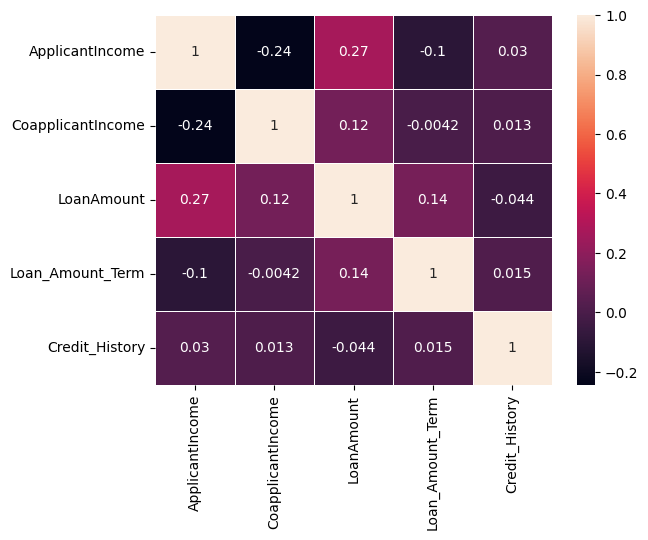

In [ ]:
corr = df.iloc[:,6:11].corr()
sns.heatmap(corr,annot = True,linewidth = 0.5);

Transformação dos dados e separação entre treino e teste.
Modelo de Regressão Logística.

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.preprocessing import StandardScaler
# regressão logística
from sklearn.linear_model import LogisticRegression

In [ ]:
df.drop('Loan_ID',axis = 1,inplace = True)

In [ ]:
df.Dependents.unique()

array(['1', '0', '2', '3+'], dtype=object)

In [ ]:
df1 = df.copy()
df1.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
1,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y


In [ ]:
labelencoder = LabelEncoder()

In [ ]:
df1.iloc[:,0] = labelencoder.fit_transform(df1.iloc[:,0])
df1.iloc[:,1] = labelencoder.fit_transform(df1.iloc[:,1])
df1.iloc[:,2] = labelencoder.fit_transform(df1.iloc[:,2])
df1.iloc[:,3] = labelencoder.fit_transform(df1.iloc[:,3])
df1.iloc[:,4] = labelencoder.fit_transform(df1.iloc[:,4])
df1.iloc[:,10] = labelencoder.fit_transform(df1.iloc[:,10])
df1.iloc[:,11] = labelencoder.fit_transform(df1.iloc[:,11])

In [ ]:
df1.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,1,1,0,0,4583,1508.0,128.0,360.0,1.0,0,0
1,1,1,0,0,1,3000,0.0,66.0,360.0,1.0,2,1


In [ ]:
sc = StandardScaler()
df1.iloc[:,5:9] = sc.fit_transform(df.iloc[:,5:9])

In [ ]:
df1.head(2)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,1,1,1,0,0,0.673893,0.091211,0.796898,0.276189,1.0,0,0
1,1,1,0,0,1,-0.410365,-0.507947,-1.316653,0.276189,1.0,2,1


In [ ]:
df1.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome      float64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [ ]:
previsores = df1.iloc[:,0:11].values
classes = df1.iloc[:,11].values

In [ ]:
classes = classes.astype(int)

In [ ]:
classes

array([0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1,

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(previsores,classes,test_size = 0.30,random_state = 0)

In [ ]:
modelo = LogisticRegression()
modelo.fit(X_train,y_train)

LogisticRegression()

In [ ]:
print(modelo.coef_)
print(modelo.intercept_)

[[ 0.4440147   0.47691209 -0.17187496 -0.25886394  0.12246249  0.01172502
  -0.09818508  0.11394664  0.01821382  3.1487993   0.05785383]]
[-2.43196129]


Valores Preditos do modelo de regressão logística

In [ ]:
previsoes = modelo.predict(X_test)
previsoes

array([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1])

Valores Observados

In [ ]:
y_test

array([1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1])

Testes e avaliações sobre os desempenhos do modelo implementado.

In [ ]:
# taxa de acertos
acuracia = accuracy_score(y_test,previsoes)
print(f"A acurácia do modelo de regressão logística foi: {round(100*acuracia,1)} %")

A acurácia do modelo de regressão logística foi: 89.2 %


In [ ]:
confusion_matrix(y_test,previsoes)

array([[11,  8],
       [ 2, 72]])

In [ ]:
from yellowbrick.classifier import ConfusionMatrix

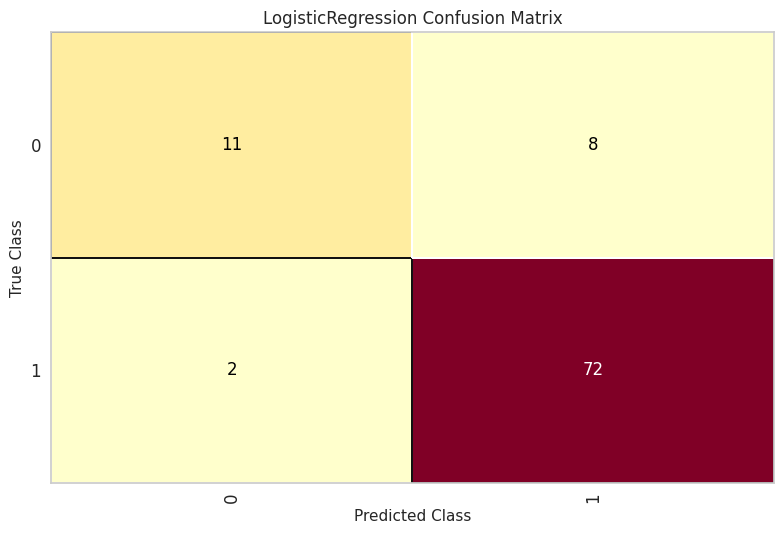

In [ ]:
v = ConfusionMatrix(modelo)
v.fit(X_train,y_train)
v.score(X_test,y_test)
v.poof();